In [1]:
!pip install keras
!pip install tensorflow

In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
import os
import cv2
from tqdm import tqdm

## augmentation, running this code will change the google drive file

In [25]:
#augment internet data
from PIL import Image
import random
import os

def random_crop_pil(image):
    w, h = image.size
    max_crop_size = min(w, h)
    crop_size = random.randint(max_crop_size // 2, max_crop_size)
    top_left_x = random.randint(0, w - crop_size)
    top_left_y = random.randint(0, h - crop_size)

    cropped = image.crop((top_left_x, top_left_y, top_left_x + crop_size, top_left_y + crop_size))
    return cropped.convert('RGB')  # Convert to RGB

def random_rotate_pil(image):
    angle = random.randint(-45, 45)  # Rotate between -45 and 45 degrees
    rotated =  image.rotate(angle)
    return rotated.convert('RGB')  # Convert to RGB

folder_path = '/content/drive/MyDrive/Capstone/image_classifier/hs_clone_for_traning'#'/content/drive/MyDrive/Capstone/image_classifier/psoriasis'

for image_file in os.listdir(folder_path):
    if image_file.lower().endswith(('.jpg', '.jpeg')):
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path)

        # Apply random crop and rotation
        processed_image = random_crop_pil(image)
        processed_image = random_rotate_pil(processed_image)

        # Save the processed image back to Google Drive
        #processed_image.save(os.path.join(folder_path, f"processed_{image_file}"))



In [26]:
X=[]
Y=[]
IMG_SIZE = 150
healthy_skin='/content/drive/MyDrive/Capstone/image_classifier/hs_clone_for_traning'
psoriasis = '/content/drive/MyDrive/Capstone/image_classifier/psoriasis'
#flowers = '/content/drive/MyDrive/adl/flowers/daisy'

def assign_label(img,label):
    return label

def load_and_process_images(label, directory, X, Y):
    for image_file in tqdm(os.listdir(directory)):
        if image_file.lower().endswith(('.jpg', '.jpeg')):  # Check for JPEG files
            full_path = os.path.join(directory, image_file)
            # Read and resize the image
            image = cv2.imread(full_path, cv2.IMREAD_COLOR)
            if image is not None:  # Check if image is loaded properly
                resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the processed image and its label to the respective lists
                X.append(np.array(resized_image))
                Y.append(label)



load_and_process_images('skin', healthy_skin, X,Y)
print(len(X))
load_and_process_images('psoriasis', psoriasis, X, Y)
print(len(X))
#load_and_process_images('other', flowers, X, Y)
print(len(X))
print('done')

100%|██████████| 342/342 [00:06<00:00, 52.85it/s] 


342


100%|██████████| 411/411 [00:04<00:00, 91.92it/s] 

724
724
done


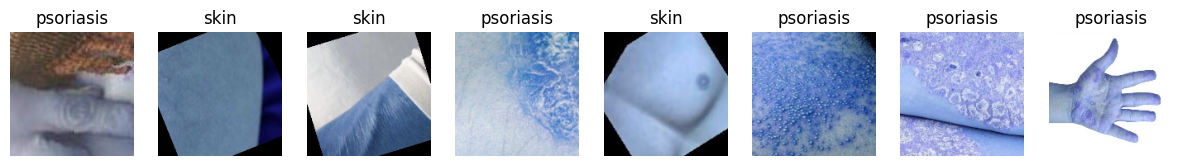

In [27]:
# Function to visualize the data
def visualize_data(images, labels, num_samples=8):
    if len(images) < num_samples:
        num_samples = len(images)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    indices = np.random.choice(range(len(images)), num_samples, replace=False)

    for i, ax in enumerate(axes):
        ax.imshow(images[indices[i]])
        ax.set_title(Y[indices[i]])
        ax.axis('off')

    plt.show()

# Convert labels back to string for visualization
label_names = ['skin', 'psoriasis','other']
Y_labels = [label_names[np.argmax(y)] for y in Y]

# Visualize the data
visualize_data(X, Y_labels)

In [28]:
# Normalize the data by dividing by 255
X_normalized = np.array(X) / 255.0
Y = np.array(Y)

# First split: Separate out a training set and a temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, Y, test_size=0.4, random_state=42)

# Second split: Divide the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # Splits the temp set evenly

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

#transform y-label
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
label_encoder = LabelEncoder()

# Fit the encoder to the labels and transform them to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

from tensorflow.keras.utils import to_categorical

# One-hot encode the integer labels
y_train = to_categorical(y_train_encoded, num_classes=5)  # Assuming 5 classes
y_val = to_categorical(y_val_encoded, num_classes=5)
y_test = to_categorical(y_test_encoded, num_classes=5)

print('after encoding shape', y_train.shape)


Training data shape: (434, 150, 150, 3)
Testing data shape: (145, 150, 150, 3)
after encoding shape (434, 5)


In [29]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3)))
#model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Fourth convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten the results to feed into a dense layer
model.add(Flatten())

# 512 neuron hidden layer
model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())

# Output layer with a single neuron for each class
model.add(Dense(5, activation='softmax')) # Assuming 5 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 35, 35, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 33, 33, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 128)      

In [53]:
def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    # Data Augmentation to prevent overfitting
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # Note: No augmentation for validation data
    validation_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
    validation_generator = validation_datagen.flow(X_val, y_val, batch_size=batch_size)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(X_val) // batch_size)

    return history


from tensorflow.keras.utils import to_categorical



# Assuming your model is named 'model'
history = train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=128)


Epoch 1/20
3/3 [==============================] - 29s 9s/step - loss: 0.6040 - accuracy: 0.6953 - val_loss: 0.6401 - val_accuracy: 0.6641
Epoch 2/20
3/3 [==============================] - 25s 7s/step - loss: 0.5589 - accuracy: 0.7157 - val_loss: 0.5720 - val_accuracy: 0.6875
Epoch 3/20
3/3 [==============================] - 23s 9s/step - loss: 0.5583 - accuracy: 0.7712 - val_loss: 0.6904 - val_accuracy: 0.6875
Epoch 4/20
3/3 [==============================] - 22s 7s/step - loss: 0.5608 - accuracy: 0.7549 - val_loss: 0.5538 - val_accuracy: 0.7266
Epoch 5/20
3/3 [==============================] - 23s 7s/step - loss: 0.5211 - accuracy: 0.7778 - val_loss: 0.5829 - val_accuracy: 0.7266
Epoch 6/20
3/3 [==============================] - 31s 10s/step - loss: 0.4954 - accuracy: 0.7891 - val_loss: 0.6177 - val_accuracy: 0.6875
Epoch 7/20
3/3 [==============================] - 26s 9s/step - loss: 0.5243 - accuracy: 0.7656 - val_loss: 0.5614 - val_accuracy: 0.7344
Epoch 8/20
3/3 [=================

5/5 [==============================] - 2s 368ms/step


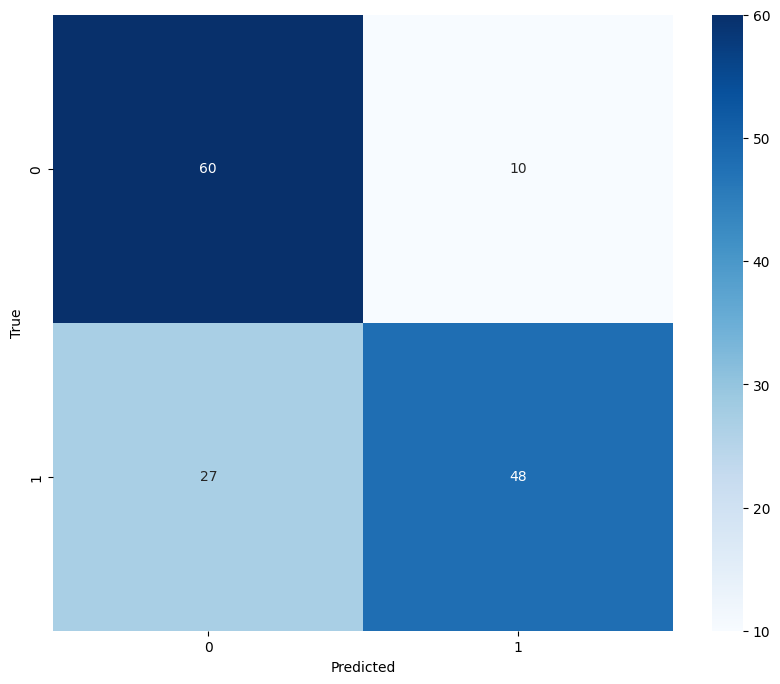

In [54]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

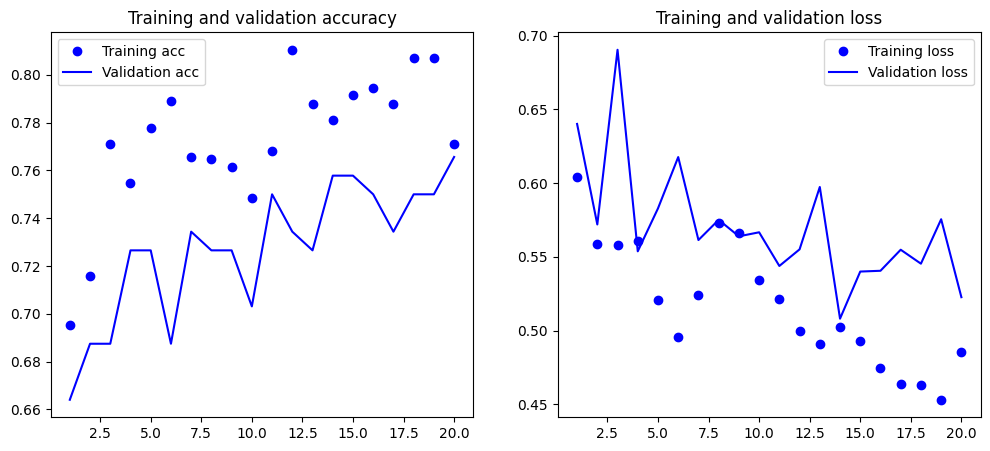

In [55]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Call the function with your history object
plot_learning_curves(history)

5/5 [==============================] - 6s 1s/step


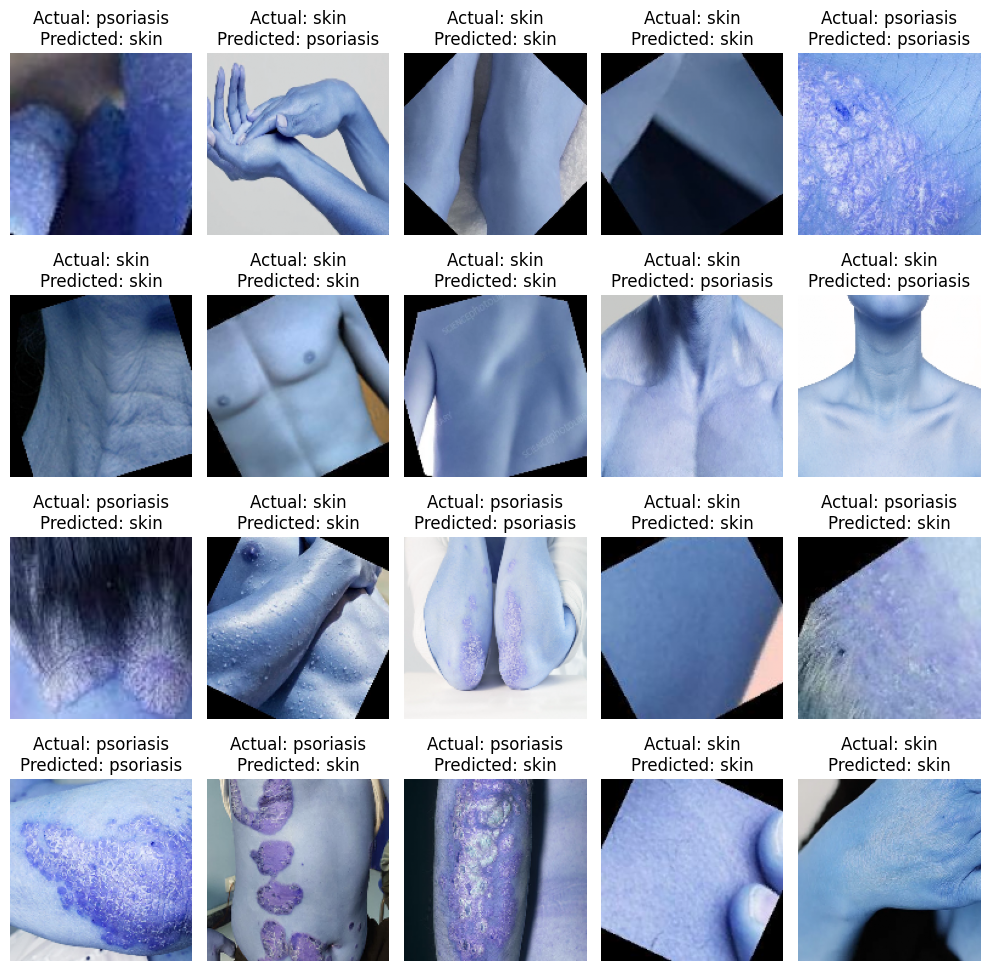

In [33]:
label_names = ['psoriasis','skin']

# Generate predictions for the test set
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)  # Use this if y_test is one-hot encoded
# true_classes = y_test  # Use this if y_test is already in integer form

# Randomly select 10 samples from the test set
num_samples = 20
random_indices = np.random.choice(len(X_test), num_samples, replace=False)


plt.figure(figsize=(10, 10))  # fig size
for i, index in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test[index])

    # Map the encoded labels back to string labels
    actual_label = label_names[true_classes[index]]
    predicted_label = label_names[predicted_classes[index]]

    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 347ms/step


ValueError: ignored

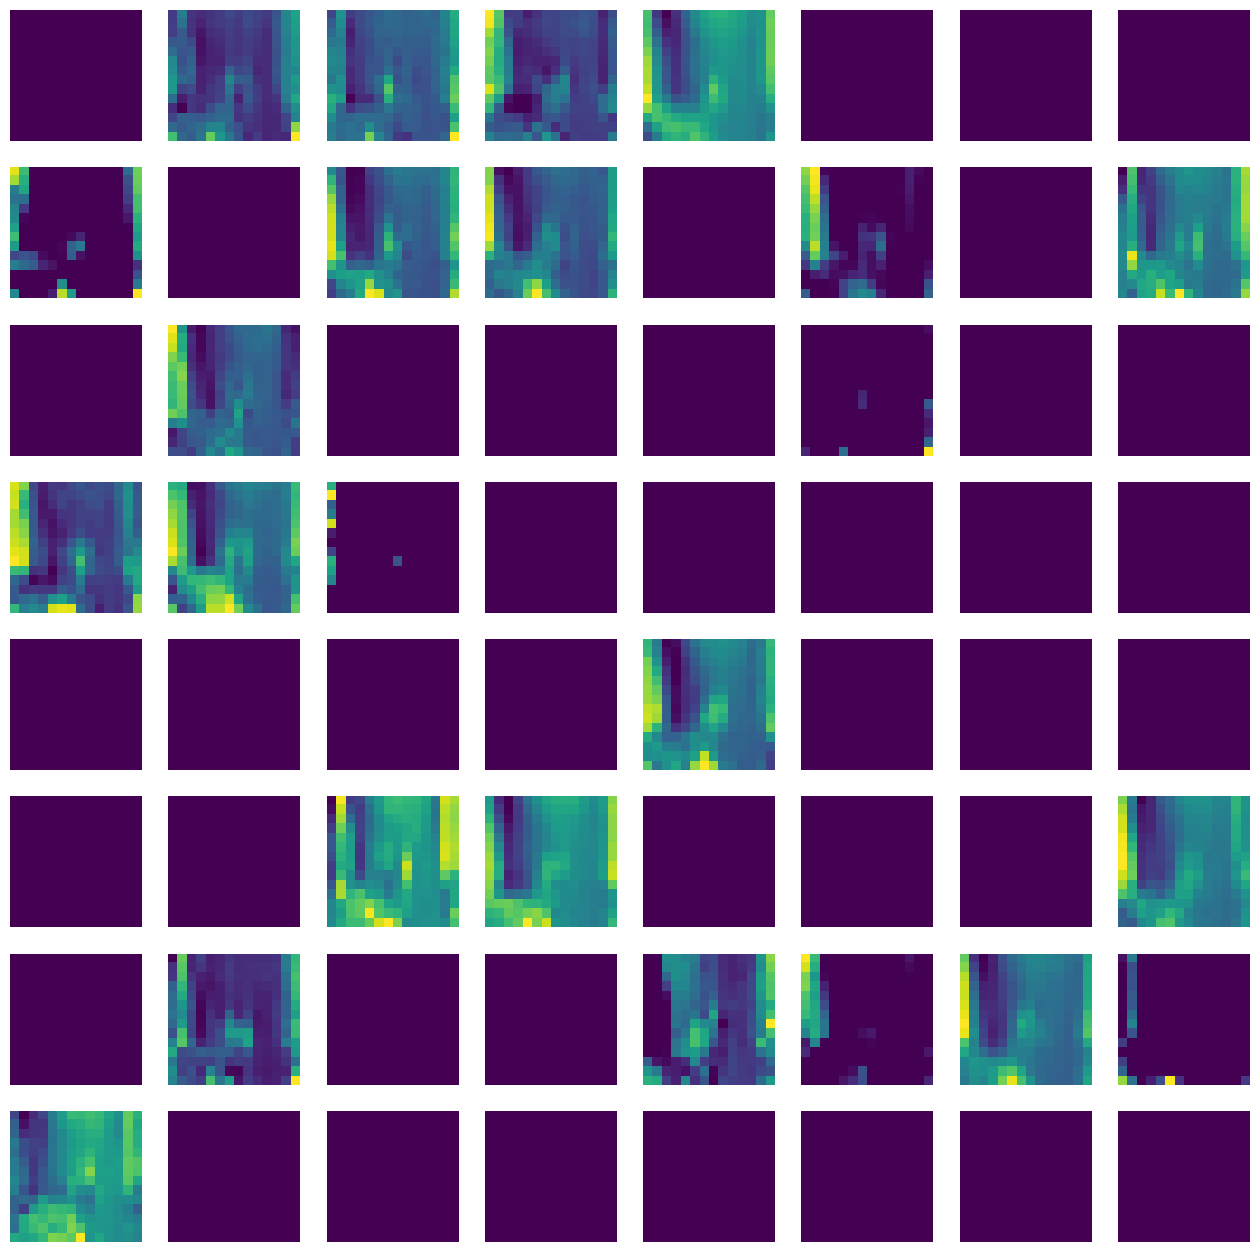

In [52]:
#feature map
from tensorflow.keras.models import Model
def visualize_feature_maps(model, layer_name, input_image):
    # Create a model to output feature maps for the specified layer
    feature_map_model = Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)

    # Get the feature map for the input image
    feature_map = feature_map_model.predict(np.array([input_image]))

    # Number of feature maps
    num_feature_maps = feature_map.shape[-1]

    # Set the number of columns for visualization
    num_cols = 8
    num_rows = 8

    # Plot each feature map
    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    for i in range(num_feature_maps):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(feature_map[0, :, :, i], cmap='viridis')
        plt.axis('off')

    plt.show()


visualize_feature_maps(model, 'conv2d_11', X_normalized[87])